<a href="https://colab.research.google.com/github/Gabrielwang4/Recommendation-System/blob/main/Meet_Fresh_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Meet Fresh Recommendation Project:
Meet Fresh is a Taiwanese dessert restaurant chain with locations in Asia, Australia, New Zealand, UK, Canada and the United States. Corporate headquarters are in New Taipei City. It Founded in 2007, the chain specializes in fresh Taiwanese desserts, including soft taro balls and herbed jelly.
The objective of the project is to build a recommendation system for Meet Fresh. The business goal is to increase the revenue for the company. 

## Load & Preprocess Data:

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
import squarify
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from math import sqrt

from sklearn.model_selection import train_test_split as train_test_split_1
from sklearn import metrics
from sklearn.metrics import mean_squared_error

from surprise.model_selection import train_test_split as train_test_split_2
from surprise import accuracy
from surprise.model_selection.validation import cross_validate
from surprise.dataset import Dataset
from surprise.reader import Reader
from surprise import SVD
from surprise.model_selection import GridSearchCV
from collections import defaultdict
from surprise.model_selection import KFold
from surprise import KNNBasic
from surprise import KNNWithMeans

from tabulate import tabulate

In [ ]:
menu = pd.read_excel('Menu.xlsx')
menu = menu.drop(0)
menu.head()

,Series-ID,Name-ID,Unique-ID,Series,Name,Ice_Hot,Calories (Kcal),Contain,Allergen,Description
1,1.0,1.0,1-1,DESSERT COMBO,Icy Taro Ball Combo A,Ice,988.0,"Taro Balls, Red Beans, Peanuts, Boba, Shaved Ice","Vegan, Gluten-Free, Lactose-Free",Our refreshing Icy Taro Ball is made from the ...
2,1.0,2.0,1-2,DESSERT COMBO,Icy Taro Ball Combo B,Ice,828.0,"Taro Balls, Taro, Red Beans, Boba, Shaved Ice","Vegan, Gluten-Free, Lactose-Free",Our refreshing Icy Taro Ball is made from the ...
3,1.0,3.0,1-3,DESSERT COMBO,Icy Taro Ball Combo C,Ice,714.0,"Taro Balls, Melon Jelly, Rice Balls, Boba, Sha...","Vegan, Gluten-Free, Lactose-Free",Our refreshing Icy Taro Ball is made from the ...
4,1.0,4.0,1-4,DESSERT COMBO,Icy Grass Jelly Combo A,Ice,702.0,"Grass Jelly, Red Beans, Peanuts, Boba, Grass J...","Vegan, Gluten-Free, Lactose-Free","In Icy Grass Jelly Combo A, toppings include o..."
5,1.0,5.0,1-5,DESSERT COMBO,Icy Grass Jelly Combo B,Ice,542.0,"Grass Jelly, Taro, Red Beans, Boba, Grass Jell...","Vegan, Gluten-Free","In Icy Grass Jelly Combo B, toppings include o..."


In [ ]:
customer = pd.read_excel('Customer Data.xlsx', sheet_name = 'Mock-Up Data (500)')
#customer = customer.drop(0)
customer.head()

,user_id,gender,age,ethnicity,sensitivity on price,sensitivity on calorie,sensitivity on seasonal food,hot or cold,current state,Rating
0,1,M,33,Asian,3,4,2,H,AZ,4
1,2,F,21,Hispanic,4,5,3,H,AZ,5
2,3,F,26,Hispanic,4,1,1,H,CA,4
3,4,M,64,Black,5,5,3,C,CA,2
4,5,M,35,Asian,5,1,2,C,CA,1


In [ ]:
transaction = pd.read_excel('Transaction Data.xlsx', sheet_name = 'Mockup_data (v4)')
#transcation = transaction.drop(0)
transaction.head()

,Record_ID,Date (mm/dd/yyyy),Customer_ID(1:500),Transaction_ID,Unique_ID,TOPPING_ID,Quantity
0,1,2016-02-01,47,1,1-14,NaN,1.0
1,2,2016-02-01,322,2,7-7,NaN,1.0
2,3,2016-02-01,186,3,13-3,NaN,1.0
3,4,2016-02-01,219,4,6-16,NaN,1.0
4,5,2016-02-01,200,5,3-12,NaN,1.0


In [ ]:
transaction_customer = pd.merge(customer, transaction, left_on = 'user_id', right_on = 'Customer_ID(1:500)', how = 'right')
transaction_customer.drop(columns = ['Customer_ID(1:500)'], inplace = True)

In [ ]:
data = pd.merge(transaction_customer, menu, left_on = 'Unique_ID', right_on = 'Unique-ID', how = 'left')
data.drop(columns = ['Unique-ID'], inplace = True)
data.head()

,user_id,gender,age,ethnicity,sensitivity on price,sensitivity on calorie,sensitivity on seasonal food,hot or cold,current state,Rating,...,Quantity,Series-ID,Name-ID,Series,Name,Ice_Hot,Calories (Kcal),Contain,Allergen,Description
0,47,F,34,Asian,5,1,3,H,CA,4,...,1.0,1.0,14.0,DESSERT COMBO,Hot Almond Soup Combo B,Hot,746.0,"Taro Balls, Taro, Red Beans, Boba, Almond Flak...","Contains Nuts (Almond), Gluten-Free",Our Seasonal Hot Almond Soup is a perfect wint...
1,322,M,32,Black,4,4,4,H,CA,5,...,1.0,7.0,7.0,TEAS,Jin Xuan Oolong Tea,Ice,434.0,NaN,NaN,NaN
2,186,F,21,Hispanic,3,3,1,C,CA,4,...,1.0,13.0,3.0,FLUFFY,Fluffy Oolong Tea,Ice,510.0,NaN,NaN,NaN
3,219,M,27,Black,3,1,2,H,CA,3,...,1.0,6.0,16.0,TOFU PUDDING,Potaro Ball Tofu Pudding,Ice,422.0,NaN,NaN,NaN
4,200,M,47,Black,4,3,4,C,CA,4,...,1.0,3.0,12.0,PURPLE RICE SERIES,Purple Rice Drink with Mini Q & Fresh Milk,Hot,873.0,NaN,NaN,NaN


In [ ]:
# Save merged data as excel file
data.to_excel('final_data.xlsx')

## Exploratory Data Analysis

In [ ]:
print(data.shape)
print(f'Data has {data.shape[0]} rows and {data.shape[1]} columns')

(131706, 25)
Data has 131706 rows and 25 columns


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131706 entries, 0 to 131705
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   user_id                       131706 non-null  int64         
 1   gender                        131706 non-null  object        
 2   age                           131706 non-null  int64         
 3   ethnicity                     131706 non-null  object        
 4   sensitivity on price          131706 non-null  int64         
 5   sensitivity on calorie        131706 non-null  int64         
 6   sensitivity on seasonal food  131706 non-null  int64         
 7   hot or cold                   131706 non-null  object        
 8   current state                 131706 non-null  object        
 9   Rating                        131706 non-null  int64         
 10  Record_ID                     131706 non-null  int64         
 11  Date (mm/dd/y

In [ ]:
# Convert user id to object type
data['user_id'] = data['user_id'].astype(object)

In [ ]:
# Check None value
data.isna().sum()

user_id                              0
gender                               0
age                                  0
ethnicity                            0
sensitivity on price                 0
sensitivity on calorie               0
sensitivity on seasonal food         0
hot or cold                          0
current state                        0
Rating                               0
Record_ID                            0
Date (mm/dd/yyyy)                    0
Transaction_ID                       0
Unique_ID                            0
TOPPING_ID                       88450
Quantity                             0
Series-ID                            0
Name-ID                              0
Series                               0
Name                                 0
Ice_Hot                          15839
Calories (Kcal)                   8677
Contain                         107437
Allergen                        101861
Description                     107758
dtype: int64

In [ ]:
# Check Statistics 
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,131706.0,32.542117,9.806544,15.00,26.00,31.0,35.00,65.0
sensitivity on price,131706.0,3.015808,1.381782,1.00,2.00,3.0,4.00,5.0
sensitivity on calorie,131706.0,3.083375,1.436838,1.00,2.00,3.0,4.00,5.0
sensitivity on seasonal food,131706.0,2.539087,1.086353,1.00,2.00,3.0,3.00,4.0
Rating,131706.0,3.234697,1.526736,1.00,2.00,4.0,5.00,5.0
Record_ID,131706.0,65853.500000,38020.391614,1.00,32927.25,65853.5,98779.75,131706.0
Transaction_ID,131706.0,32389.604187,18709.901238,1.00,16134.00,32620.0,48548.00,64682.0
Quantity,131706.0,1.485311,3.872667,0.01,1.00,1.0,1.00,400.0
Series-ID,131706.0,9.488945,5.155308,1.00,5.00,9.0,14.00,18.0
Name-ID,131706.0,4.736466,3.614783,1.00,2.00,4.0,6.00,18.0


In [ ]:
# Check unique number of each column
for col in data.columns:
    print(col)
    print(data[col].nunique())
    print(data[col].unique())
    print()

user_id
500
[47 322 186 219 200 10 166 253 41 48 365 44 92 450 374 99 223 421 294 280
 116 124 58 236 71 65 66 303 276 459 46 95 22 438 179 316 391 155 383 297
 21 476 324 285 98 112 15 208 97 473 11 220 414 125 62 113 96 37 492 488
 104 108 283 373 265 352 448 30 122 481 128 470 268 88 178 221 225 494 344
 3 427 235 170 457 408 23 326 332 131 141 348 85 195 204 355 264 443 339
 159 288 317 126 77 117 114 314 401 454 110 293 45 343 135 399 278 156 180
 192 376 306 493 354 275 227 191 422 53 4 407 284 224 262 34 251 337 201
 257 417 394 308 327 413 226 57 406 100 418 2 24 289 238 218 340 267 80
 149 341 471 478 157 362 132 325 445 87 160 134 145 356 358 304 475 400
 363 6 83 136 43 411 477 387 315 252 8 424 35 176 484 274 185 404 446 31
 290 311 380 323 60 449 36 241 263 237 259 254 206 300 349 143 38 151 353
 367 245 439 309 175 497 130 372 270 169 444 211 94 375 231 106 242 302
 319 405 167 489 207 434 272 246 184 75 205 101 452 279 68 330 82 295 138
 490 491 232 139 428 350 72 127 43

18
[ 1.  7. 13.  6.  3. 17. 11. 10.  8.  5.  9. 15. 12. 16. 14.  4. 18.  2.]

Name-ID
18
[14.  7.  3. 16. 12.  6.  4.  1.  9. 10.  2.  8. 15.  5. 11. 18. 13. 17.]

Series
18
['DESSERT COMBO' 'TEAS' 'FLUFFY' 'TOFU PUDDING' 'PURPLE RICE SERIES'
 'EGG WAFFLE' 'WINTER MELON TEAS' 'FRESH MILK' 'HERBAL TEAS'
 'SOFT SERVE SERIES' 'MILK TEAS' 'COFFEE SERIES' 'SLUSH' 'SEASONAL DRINKS'
 'FRUIT SERIES' 'SHAVED ICE' 'SMALL BITES' 'SIGNATURE SERIES']

Name
125
['Hot Almond Soup Combo B' 'Jin Xuan Oolong Tea' 'Fluffy Oolong Tea'
 'Potaro Ball Tofu Pudding' 'Purple Rice Drink with Mini Q & Fresh Milk'
 'Chocolate Deluxe' 'QQ Winter Melon Tea' 'Fresh Milk Winter Melon Tea'
 'Fresh Milk Oolong Tea'
 'Miss You Drink (Red Bean Soup with Hot Grass Jelly)' 'Creamy Milk'
 'Fluffy Mini Q (Mini Taro Ball) Winter Melon Tea'
 'Purple Rice with Fresh Milk' 'Boba Milk Tea' 'Coffee Smoothie'
 'Fluffy Green Tea' 'Original' 'Mango Green Tea Slush'
 'Mini Q & Melon Jelly' 'Mini Q (Mini Taro Ball) Hot Almond Drink'
 '

In [ ]:
# drop columns 'Record_ID'.
data.drop(columns = 'Record_ID', inplace = True)

### Rating Distribution

<AxesSubplot:title={'center':'Distribution of Rating'}>

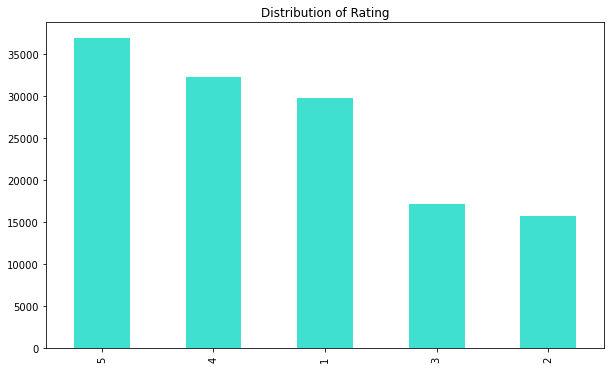

In [ ]:
data['Rating'].value_counts().plot(kind = 'bar', title = 'Distribution of Rating', figsize = (10, 6), color = 'turquoise')

The users who have rated 5 is the most, then followed by rating 4 and 1. The users who have rated 2 and 3 are relatively less.

### Rating Count Distribution grouped by Items

<AxesSubplot:title={'center':'Rating Counts grouped by Items'}, ylabel='Frequency'>

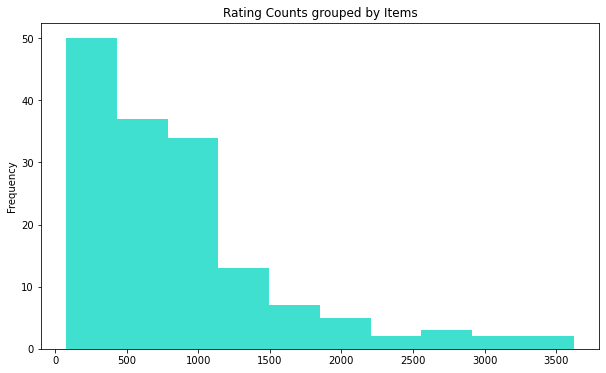

In [ ]:
data['Unique_ID'].value_counts().plot(kind = 'hist', title = 'Rating Counts grouped by Items', figsize = (10, 6), color = 'turquoise')

From the plot of rating counts distribution grouped by all the items, we can see there are many items which were rated more than 20, also many items which were rated less than 5.

### Rating Count Distribution grouped by Users

<AxesSubplot:title={'center':'Rating Counts grouped by Users'}, ylabel='Frequency'>

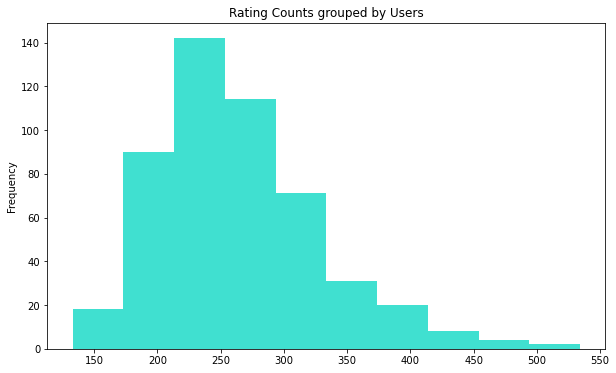

In [ ]:
data['user_id'].value_counts().plot(kind = 'hist', title = 'Rating Counts grouped by Users', figsize = (10, 6), color = 'turquoise')

From the plot of rating counts distribution grouped by all the users, we can see there are many users who have rated more than 20, less users have rated less than 20.

### Correlation Analysis

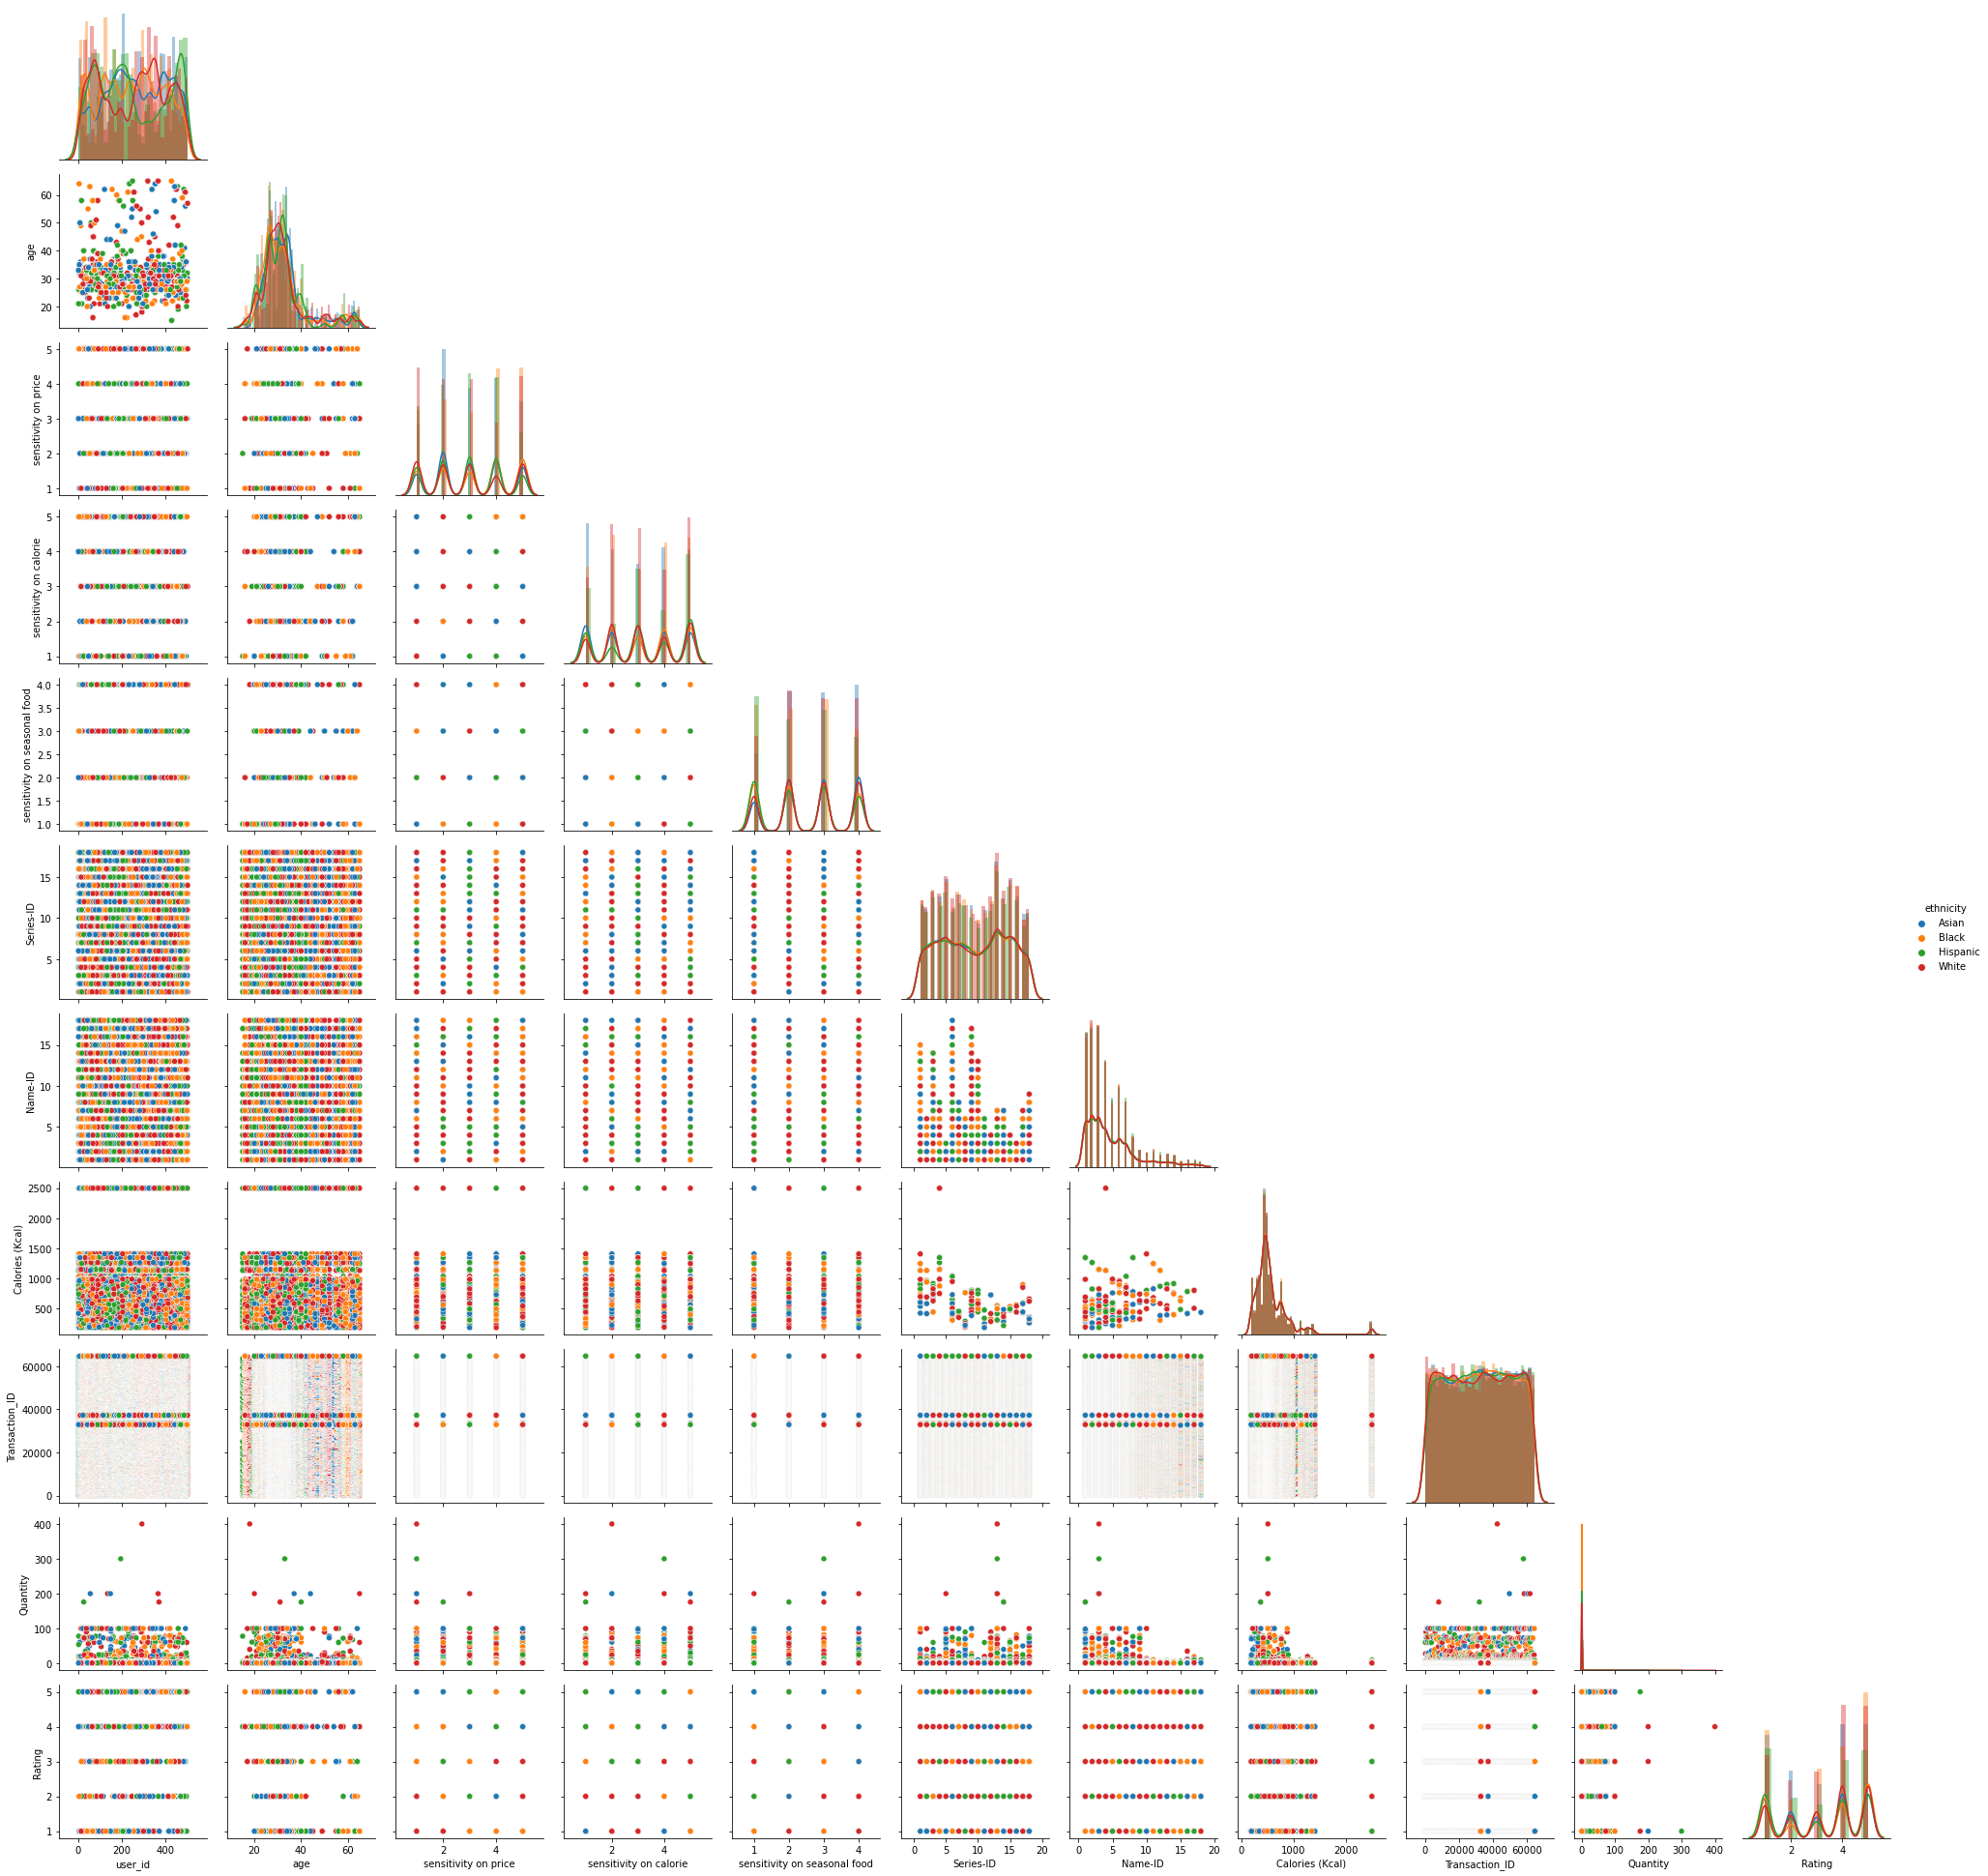

In [ ]:
# Map each variable onto a column and row in a grid of multiple axes
g = sns.PairGrid(data, vars = ['user_id', 'age', 'sensitivity on price', 'sensitivity on calorie', 
                               'sensitivity on seasonal food', 'Series-ID', 'Name-ID', 'Calories (Kcal)', 'Transaction_ID', 'Quantity', 'Rating'],
                diag_sharey = False, corner = True, hue = 'ethnicity')
g.map_lower(sns.scatterplot)
g.map_diag(sns.distplot)
g.add_legend()

In [ ]:
# correlation
data.corr()

,age,sensitivity on price,sensitivity on calorie,sensitivity on seasonal food,Rating,Transaction_ID,Quantity,Series-ID,Name-ID,Calories (Kcal)
age,1.000000,0.010398,-0.011571,-0.033315,-0.000218,-0.009626,-0.001638,0.000065,0.000102,0.000433
sensitivity on price,0.010398,1.000000,0.007742,0.052349,0.000304,-0.007739,-0.008565,-0.006004,0.006296,0.006873
sensitivity on calorie,-0.011571,0.007742,1.000000,-0.023697,-0.073966,0.003755,-0.001388,-0.003705,-0.002399,-0.009238
sensitivity on seasonal food,-0.033315,0.052349,-0.023697,1.000000,0.062691,-0.000686,0.003827,-0.001275,-0.003617,0.004384
Rating,-0.000218,0.000304,-0.073966,0.062691,1.000000,0.006253,0.003311,-0.003414,0.003250,0.002499
Transaction_ID,-0.009626,-0.007739,0.003755,-0.000686,0.006253,1.000000,0.002736,-0.000282,0.000651,-0.007443
Quantity,-0.001638,-0.008565,-0.001388,0.003827,0.003311,0.002736,1.000000,0.016229,-0.016395,-0.009991
Series-ID,0.000065,-0.006004,-0.003705,-0.001275,-0.003414,-0.000282,0.016229,1.000000,-0.251660,-0.444716
Name-ID,0.000102,0.006296,-0.002399,-0.003617,0.003250,0.000651,-0.016395,-0.251660,1.000000,0.168118
Calories (Kcal),0.000433,0.006873,-0.009238,0.004384,0.002499,-0.007443,-0.009991,-0.444716,0.168118,1.000000


<AxesSubplot:>

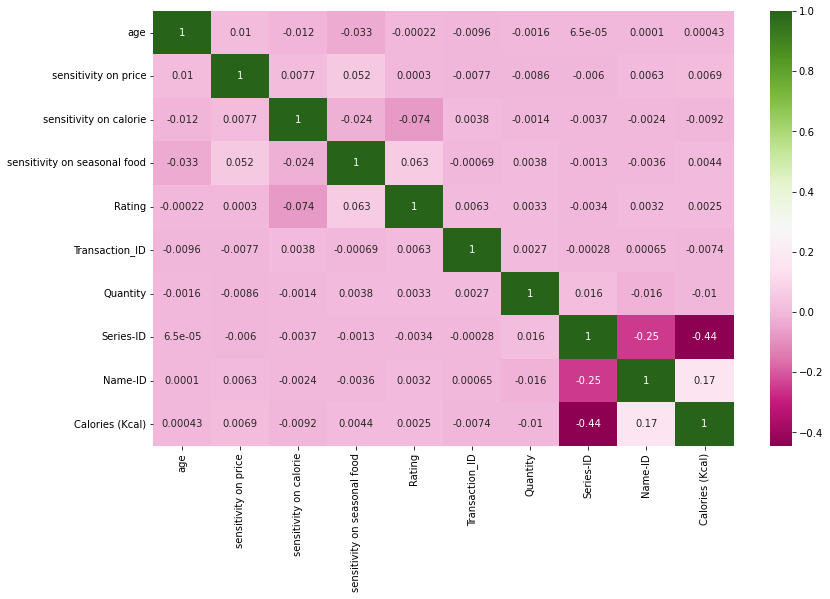

In [ ]:
# heatmap
plt.figure(figsize = (13, 8))
sns.heatmap(data = data.corr(), cmap = 'PiYG', annot = True)

There are no obvious relationship between features except Series-ID/Name-ID vs Calories. The variables are independent.

## Recommendation System 1
### Popularity based recommendation system
Popularity based recommendation system works on the principle of popularity and or anything which is in trend. It targets at new customers. It ranked items based on its popularity like the rating count. If a item is highly rated then it is most likely to be ranked higher and hence will be recommended. As it is based on the item popularity, this can not be personalized.

In [ ]:
data_popularity = data.copy()
data_popularity = data_popularity[['user_id', 'Unique_ID', 'Rating']]

In [ ]:
# Drop duplicates
# data_popularity.drop_duplicates(keep='first', inplace=True, ignore_index=False)

In [ ]:
# Extract required features
train_data, test_data = train_test_split_1(data_popularity, test_size = 0.3, random_state = 2)
print(f'Training set has {train_data.shape[0]} rows and {train_data.shape[1]} columns')
print(f'Testing set has {test_data.shape[0]} rows and {test_data.shape[1]} columns')

Training set has 92194 rows and 3 columns
Testing set has 39512 rows and 3 columns


In [ ]:
class popularity_recommender():
    def __init__(self, train_data, test_data, user_id, item_id):
        self.train_data = train_data
        self.test_data = test_data
        self.user_id = user_id
        self.item_id = item_id
        self.popularity_recommendations = None
        
    # Create popularity based mode    
    def fit(self):
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'user_id': 'score'}, inplace = True)
        
        # Sort items based on recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0, 1])
        
        # Generate a rank based on score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending = 0, method = 'first')
        
        # Get top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(10)
        
    # Make recommendations by popularity based model
    def recommenders(self, user_id, n = 10):
        user_recommendations = self.popularity_recommendations
        
        # Filter items that are not rated by the user
        items_rated = self.train_data[self.train_data[self.user_id] == user_id][self.item_id]
        user_recommendations = user_recommendations[~user_recommendations[self.item_id].isin(items_rated)]
        
        # Add user_id column
        user_recommendations['user_id'] = user_id
        
        # Bring user_id column to the front of dataframe
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols].head(n)
        self.plot(user_recommendations)
        return user_recommendations
    
    def plot(self, user_recommendations):
        sns.set_style('darkgrid')
        sns.set_palette('Set2')
        fig, axes = plt.subplots(1, 2, figsize = (10, 6))
        plot1 = sns.barplot(x = 'Rank', y = 'score', data = user_recommendations, ax = axes[0])
        plot2 = sns.pointplot(x = 'Rank', y = 'score', data = user_recommendations, ax = axes[1])
        plt.show()
             
    def predict_evaluate(self):
        ratings = pd.DataFrame(self.train_data.groupby(self.item_id)['Rating'].mean())
        pred_ratings = []
        for v in self.test_data.values:
            if (v[1] in (ratings.index)):
                pred_ratings.append(ratings.loc[v[1]])
            else:
                pred_ratings.append(0)
                
        mse = mean_squared_error(self.test_data['Rating'], pred_ratings)
        rmse = sqrt(mse)
        return rmse

### Fit Model & Get Recommendations

In [ ]:
rec = popularity_recommender(train_data = train_data, test_data = test_data, user_id = 'user_id', item_id = 'Unique_ID')
rec.fit()

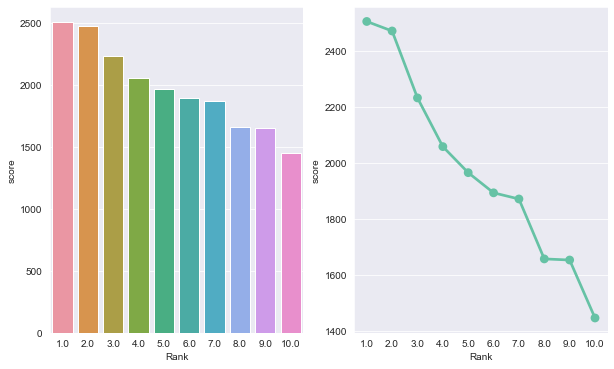

,user_id,Unique_ID,score,Rank
56,6,16-1,2505,1.0
104,6,5-2,2471,2.0
40,6,13-3,2232,3.0
54,6,15-3,2058,4.0
103,6,5-1,1965,5.0
35,6,12-2,1893,6.0
44,6,13-7,1871,7.0
58,6,16-3,1657,8.0
105,6,5-3,1653,9.0
53,6,15-2,1446,10.0


In [ ]:
popu_user1 = rec.recommenders('6')
popu_user1

In [ ]:
pop_user_6 = pd.merge(popu_user1, menu, left_on = 'Unique_ID', right_on = 'Unique-ID', how = 'inner')
#na.drop(columns = ['Unique-ID'], inplace = True)
pop_user_6[['user_id', 'Unique_ID', 'Name', 'score', 'Rank']]

,user_id,Unique_ID,Name,score,Rank
0,6,16-1,Hot Almond Drink,2505,1.0
1,6,5-2,Mini Q & Melon Jelly,2471,2.0
2,6,13-3,Fluffy Oolong Tea,2232,3.0
3,6,15-3,Coffee Smoothie,2058,4.0
4,6,5-1,Creamy Milk,1965,5.0
5,6,12-2,Mixed Fruit Green Tea Slush,1893,6.0
6,6,13-7,Fluffy Mini Q (Mini Taro Ball) Winter Melon Tea,1871,7.0
7,6,16-3,Mini Q (Mini Taro Ball) Hot Almond Drink,1657,8.0
8,6,5-3,Boba & Caramel Pudding,1653,9.0
9,6,15-2,Coffee Milk Tea,1446,10.0


In [ ]:
#table = tabulate(na[['user_id', 'Unique_ID', 'Name', 'score', 'Rank']], headers = 'keys', tablefmt = 'psql')
#print(table)

In [ ]:
# Save table as a txt file
#import os
#with open("C:\\Users\\bnmwe\\Desktop\DS\\popularity_user_id_6.txt", "w") as outf:
    #outf.write(table)
#os.startfile("C:\\Users\\bnmwe\\Desktop\DS\\popularity_user_id_6.txt", "print")

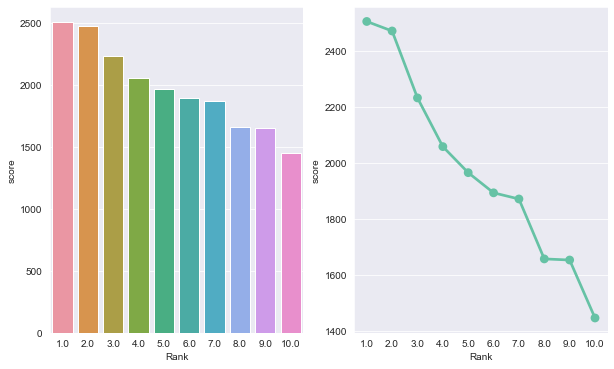

,user_id,Unique_ID,score,Rank
56,200,16-1,2505,1.0
104,200,5-2,2471,2.0
40,200,13-3,2232,3.0
54,200,15-3,2058,4.0
103,200,5-1,1965,5.0
35,200,12-2,1893,6.0
44,200,13-7,1871,7.0
58,200,16-3,1657,8.0
105,200,5-3,1653,9.0
53,200,15-2,1446,10.0


In [ ]:
popu_user2 = rec.recommenders('200')
popu_user2

In [ ]:
pop_user_200 = pd.merge(popu_user2, menu, left_on = 'Unique_ID', right_on = 'Unique-ID', how = 'inner')
pop_user_200[['user_id', 'Unique_ID', 'Name', 'score', 'Rank']]

,user_id,Unique_ID,Name,score,Rank
0,200,16-1,Hot Almond Drink,2505,1.0
1,200,5-2,Mini Q & Melon Jelly,2471,2.0
2,200,13-3,Fluffy Oolong Tea,2232,3.0
3,200,15-3,Coffee Smoothie,2058,4.0
4,200,5-1,Creamy Milk,1965,5.0
5,200,12-2,Mixed Fruit Green Tea Slush,1893,6.0
6,200,13-7,Fluffy Mini Q (Mini Taro Ball) Winter Melon Tea,1871,7.0
7,200,16-3,Mini Q (Mini Taro Ball) Hot Almond Drink,1657,8.0
8,200,5-3,Boba & Caramel Pudding,1653,9.0
9,200,15-2,Coffee Milk Tea,1446,10.0


### Model evaluation by MSE and RMSE

In [ ]:
rec.predict_evaluate()

1.5280694746384151

### RMSE is small, model works well. Since this is a popularity based recommender model, we get same result for both users i.e. the model recommends same items for all the users.

## Recommendation System 2
### Collaborative filtering recommender model using surprise library
Surprise is a python scikit for building and analying recommender systems that deal with explicit rating data. 
Collaborative filtering relies on the assumption that similar users like similar items. Similarity measures between users and/or items are used to make recommendations. Matrix factorization is a very popular collaborative filtering technique.  
SVD is a matrix factorization technique that is usually used to reduce the no.of features of a dataset by reducing space dimensions from N to K. It provides another way to factorize a matrix into singular vectors and singular values.    

$$A = U.Sigma.V$$

In [ ]:
data_df = data.copy()
data_df = data[['user_id', 'Unique_ID', 'Rating']]

In [ ]:
data_df.drop_duplicates(keep='first', inplace=True, ignore_index=False)

In [ ]:
reader = Reader()
surprise_data = Dataset.load_from_df(data_df, reader)
trainset, testset = train_test_split_2(surprise_data, test_size = 0.3, random_state = 2)

In [ ]:
def get_top_n(predictions, n = 10):
    
    # Map the predictions to each user
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
     
    # Sort user ratings by estimated value
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

In [ ]:
class recommender_model():
    
    def __init__(self, model, trainset, testset, data):
        self.model = model
        self.trainset = trainset
        self.testset = testset
        self.data = data
        self.pred_test = None
        self.top_n = None
        self.recommenddf = None
     
    # Fit model and predict
    def fit_predict(self):
        
        print('Fitting the train data: ')
        self.model.fit(self.trainset)
        print('Predicting the test data: ')
        self.pred_test = self.model.test(self.testset)
        rmse = round(accuracy.rmse(self.pred_test), 3)
        print('RMSE for the predicted result is ' + str(rmse))
        
        self.top_n = get_top_n(self.pred_test)
        self.recommenddf = pd.DataFrame(columns = ['user_id', 'Unique_ID', 'Rating'])
        
        for item in self.top_n:
            subdf = pd.DataFrame(self.top_n[item], columns = ['Unique_ID', 'Rating'])
            subdf['user_id'] = item
            cols = subdf.columns.tolist()
            cols = cols[-1:] + cols[:-1]
            subdf = subdf[cols]
            self.recommenddf = pd.concat([self.recommenddf, subdf], axis = 0)
                
        return rmse
    
    # Define cross validation function
    def cross_validate(self):
        
        print('Cross validate the data: ')
        cv_result = cross_validate(self.model, self.data, n_jobs = -1)
        cv_result = round(cv_result['test_rmse'].mean(), 3)
        print('Mean CV RMSE is ' + str(cv_result)) 
        
        return cv_result
    
    # Recommend data frame
    def recommend(self, user_id, n =5):
        
        df = self.recommenddf[self.recommenddf['user_id'] == user_id].head(n)
        display(df)
        
        return df
                    

### Tuning hyperparameters by GridSearch

In [ ]:

def best_model(model, parameters, data):
    
    gs = GridSearchCV(model, parameters, n_jobs = -1, measures = ['rmse'], cv = 3)
    gs.fit(data)
    
    print(gs.best_score)
    print(gs.best_params)
    print(gs.best_estimator)
    
    return gs

In [ ]:
param_grid = {'n_epochs': [5, 10],
             'lr_all': [0.002, 0.005],
             'reg_all': [0.4, 0.6]}
gs = best_model(SVD, param_grid, surprise_data)

{'rmse': 0.4415853135516778}
{'rmse': {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}}
{'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000001CF502501C8>}


In [ ]:
svd = gs.best_estimator['rmse']
svd_model  = recommender_model(svd, trainset, testset, surprise_data)

### Evaluate model performance by RMSE and Cross validate

In [ ]:
svd_rmse = svd_model.fit_predict()

Fitting the train data: 
Predicting the test data: 
RMSE: 0.4380
RMSE for the predicted result is 0.438


In [ ]:
svd_cv_rmse = svd_model.cross_validate()

Cross validate the data: 
Mean CV RMSE is 0.433


### Evaluate model performance recall

An item is considered relevant if its true rating $r_{ui}$ is greater than a given threshold. An item is considered recommended if its estimated rating $\hat{r}_{ui}$ is greater than the threshold, and if it is among the k highest estimated ratings.

$$Recall@k = \frac{\textrm{Recommended  items  that  are  relevant}}{\textrm{Relevant  items}}$$

In [ ]:
def recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return recalls

In [ ]:
svd = SVD(n_epochs = 10, lr_all = 0.005, reg_all = 0.4)

In [ ]:
svd.fit(trainset)
predictions = svd.test(testset)
recalls = recall_at_k(predictions, k = 10, threshold = 4.5)

# Recall can then be averaged over all users
print('Recall value is: ' + str(sum(rec for rec in recalls.values()) / len(recalls)))

Recall value is: 0.8071460930114435


### Recommends 10 items to the user based on the user's rating behavior

In [ ]:
# Recommend 10 relevant items to user_id of 8
svd_user1 = svd_model.recommend(user_id = 8, n = 10)

,user_id,Unique_ID,Rating
0,8,7-5,3.809649
1,8,3-5,3.808862
2,8,18-2,3.808583
3,8,3-6,3.807798
4,8,8-4,3.807275
5,8,6-1,3.799882
6,8,3-13,3.798697
7,8,10-8,3.797762
8,8,2-2,3.795704
9,8,9-8,3.792619


In [ ]:
svd_user_8 = pd.merge(svd_user1, menu, left_on = 'Unique_ID', right_on = 'Unique-ID', how = 'inner')
svd_user_8[['user_id', 'Unique_ID', 'Name', 'Rating']]

,user_id,Unique_ID,Name,Rating
0,8,7-5,Oolong Tea,3.809649
1,8,3-5,Purple Rice Soup Combo C,3.808862
2,8,18-2,Red Bean Almond Pudding,3.808583
3,8,3-6,Hot Almond Purple Rice Soup,3.807798
4,8,8-4,Fresh Milk Herbal Tea,3.807275
5,8,6-1,Plain Tofu Pudding,3.799882
6,8,3-13,Purple Rice Drink with Boba & Fresh Milk,3.798697
7,8,10-8,Fresh Milk Jin Xuan Tea,3.797762
8,8,2-2,Icy Grass Jelly Signature,3.795704
9,8,9-8,Jin Xuan Oolong Milk Tea,3.792619


In [ ]:
# Recommend 10 relevant items to user_id of 300
svd_user2 = svd_model.recommend(user_id = 300, n = 10)

,user_id,Unique_ID,Rating
0,300,9-9,3.829131
1,300,9-13,3.812130
2,300,6-10,3.808450
3,300,13-1,3.805746
4,300,4-1,3.802911
5,300,2-4,3.801854
6,300,6-11,3.801108
7,300,7-5,3.800645
8,300,18-2,3.800621
9,300,8-4,3.800361


In [ ]:
svd_user_300 = pd.merge(svd_user2, menu, left_on = 'Unique_ID', right_on = 'Unique-ID', how = 'inner')
svd_user_300[['user_id', 'Unique_ID', 'Name', 'Rating']]

,user_id,Unique_ID,Name,Rating
0,300,9-9,Boba Milk Tea,3.829131
1,300,9-13,Pudding Milk Tea,3.812130
2,300,6-10,Taro Ball Tofu Pudding,3.808450
3,300,13-1,Fluffy Black Tea,3.805746
4,300,4-1,Red Bean Milk Shaved Ice,3.802911
5,300,2-4,Hot Red Bean Soup Signature,3.801854
6,300,6-11,Taro Ball Tofu Pudding,3.801108
7,300,7-5,Oolong Tea,3.800645
8,300,18-2,Red Bean Almond Pudding,3.800621
9,300,8-4,Fresh Milk Herbal Tea,3.800361


SVD model has a test RMSE value of 0.438 and cross_validation RMSE value of 0.433. It achieved the Recall@10 of 0.8071, which means that about 80% of relevant items in test set were ranked by our model among the top-10 items. This is pretty good. As for the recommendations, each user will have differeent items as they are infered by filling out missing entries in the matrix during matrix factorization using SVD. This is more useful when the data is sparse with many missing ratings.

### Model-based Collaborative filtering is a personalised recommender system, the recommendations are based on the past behavior of the user. In our case, each user has different items recommended to them as they are inferred based on the ratings provided by the similar users.